In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
import lightgbm as lgb

In [2]:
weather = pd.read_csv('data/weather_v2.csv')
target = pd.read_csv('data/target_v2.csv')

/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (25) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# 2. 모델 구축 시 사용할 지점 및 기상 속성 선정 과정

## 사용 지점 (4곳)
- 제주, 고산, 성산, 서귀포 (ASOS 지점)

## 선정 이유
- 전국적으로 ASOS에서 관측한 기온이 공식으로 인정 받기 때문에 ASOS 기온만 사용해볼 것이다.
출처: https://www.hankyung.com/society/article/201807242843Y

- 사용 기상 속성
    - 제주: 기온
    - 고산: 기온
    - 성산: 기온
    - 서귀포: 기온

## 선정 이유
- 기온은 결측값이 가장 적음과 동시에, smp 및 supply와의 상관관계도 기타 속성에 비해 강한 편이다

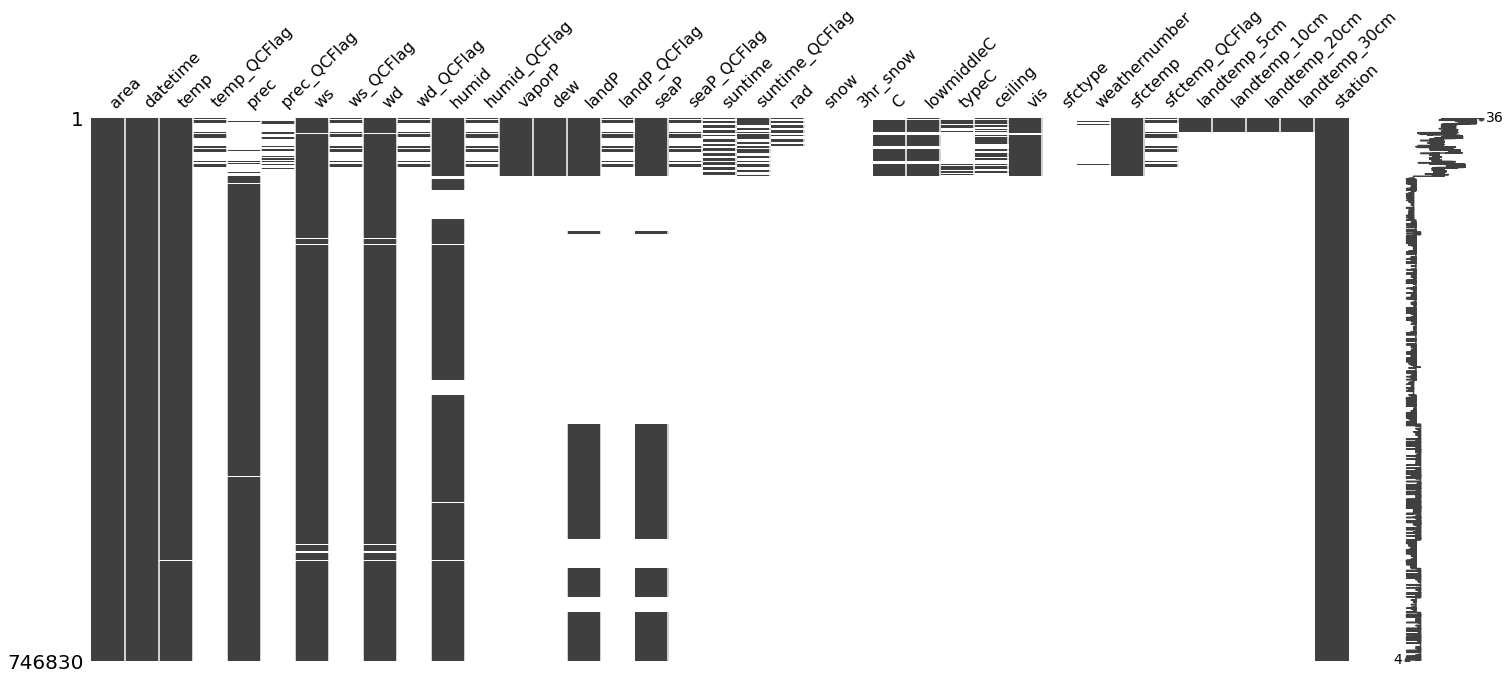

In [3]:
# 결측치 확인
import missingno as msno
msno.matrix(weather)

In [4]:
weather['date'] = weather['datetime'].apply(lambda x : x[:10])
weather_mean = weather.groupby('date').mean().reset_index(drop = True)

In [5]:
# 평균 상관관계 확인 
pd.concat([target, weather_mean], axis = 1).corr().loc['smp_max':'supply','area':].abs().mean().sort_values(ascending = False).head(10)

landtemp_30cm    0.323563
landtemp_5cm     0.300492
landtemp_20cm    0.293111
landtemp_10cm    0.292360
temp             0.291700
sfctemp          0.283049
dew              0.269303
vaporP           0.246189
landP            0.223619
seaP             0.182458
dtype: float64

# 3. 데이터 전처리
## target
- target의 date에서 년, 월, 일, 요일을 찾아 추가


## weather
- ASOS 지역의 기온만을 사용
- 기온는 지역별 기온의 중앙값만을 사용
- 선정된 시간별 기온에서 그 날의 최소기온, 최고기온, 평균기온를 찾아 target에 추가

In [6]:
target['date'] = pd.to_datetime(target['date'])

target['year'] = target['date'].dt.year
target['month'] = target['date'].dt.month
target['day'] = target['date'].dt.day
target['dayofweek'] = target['date'].dt.dayofweek

In [7]:
target.head()

date  smp_max  smp_min  smp_mean  supply  year  month  day  dayofweek
0 2018-02-01   150.65   116.84    132.71   87.47  2018      2    1          3
1 2018-02-02   163.86   116.84    134.19   86.64  2018      2    2          4
2 2018-02-03   164.07   116.85    131.39   88.28  2018      2    3          5
3 2018-02-04   171.00   115.76    131.89   86.14  2018      2    4          6
4 2018-02-05   170.34   123.89    137.96   90.63  2018      2    5          0

In [8]:
weather = weather[weather['station'] == 'ASOS']

In [9]:
weather['datetime'] = pd.to_datetime(weather['datetime'])
weather = weather.loc[:,'area':'temp']

In [10]:
weather_list = []
for area in weather['area'].unique():
    weather_list.append(weather[weather['area']==area].copy())
    
for i, area in enumerate(weather['area'].unique()):
    weather_list[i].drop(['area'], axis=1, inplace=True)
    weather_list[i].columns = ['datetime', str(area)+'_temp']

In [11]:
start = '2018-02-01'
end = '2020-05-18'
hourly_temperature = pd.DataFrame(columns = ['datetime'])
date_range = pd.date_range(start, end, freq='H')
hourly_temperature['datetime'] = date_range

for d in weather_list:
    hourly_temperature  = hourly_temperature.merge(d, how='outer')
hourly_temperature['median'] = hourly_temperature.median(axis=1)
hourly_temperature = hourly_temperature.loc[:,['datetime', 'median']]
hourly_temperature.columns = ['date', 'temperature']

In [12]:
# 결측치는 1시간 후 온도로 처리
hourly_temperature['temperature'][hourly_temperature['temperature'].isna()] = hourly_temperature.shift(-1)['temperature'][hourly_temperature['temperature'].isna()]

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [13]:
start = '2018-02-01'
end = '2020-05-18'
daily_temperature = pd.DataFrame(columns = ['date'])
date_range = pd.date_range(start, end, freq='D')
daily_temperature['date'] = date_range

In [14]:
for d in range(daily_temperature.shape[0]):
    for h in range(24):
        daily_temperature.loc[d, 'temp_h'+str(h)] = hourly_temperature['temperature'][d*24:d*24+24][d*24+h]

In [15]:
daily_temperature['temp_max'] = daily_temperature.loc[:,'temp_h0':].max(axis=1)
daily_temperature['temp_min'] = daily_temperature.loc[:,'temp_h0':].min(axis=1)
daily_temperature['temp_mean'] = daily_temperature.loc[:,'temp_h0':].mean(axis=1)

In [16]:
daily_temperature.head()

date  temp_h0  temp_h1  temp_h2  temp_h3  temp_h4  temp_h5  temp_h6  \
0 2018-02-01     3.80     3.80     3.95     3.75     3.35     3.45      3.6   
1 2018-02-02     3.20     2.85     2.75     2.60     2.60     2.70      2.6   
2 2018-02-03     3.90     4.00     3.80     3.70     3.35     2.75      2.9   
3 2018-02-04    -0.65    -1.20    -1.35    -0.70    -1.65    -1.55     -1.4   
4 2018-02-05    -0.95    -1.70    -1.45    -1.15    -0.95    -0.60     -0.2   

   temp_h7  temp_h8  ...  temp_h17  temp_h18  temp_h19  temp_h20  temp_h21  \
0     3.65     3.70  ...      5.00      4.25      4.15      4.00      3.75   
1     2.45     2.55  ...      4.10      3.85      3.95      3.95      3.85   
2     1.35     1.55  ...      0.30      0.20      0.25     -0.20     -0.50   
3    -2.05    -1.60  ...     -0.80     -1.00     -0.65     -1.20     -1.00   
4    -0.25    -0.70  ...      1.45      1.20      0.10      0.20      0.55   

   temp_h22  temp_h23  temp_max  temp_min  temp_mean  
0      3.40       3.3      5.95      3.30   4.298077  
1      3.95       4.0      5.25      2.45   3.576923  
2     -0.30      -0.2      4.00     -0.50   1.457692  
3     -1.30      -1.2      0.30     -2.05  -1.000000  
4      0.15      -0.7      2.05     -1.70   0.015385  

[5 rows x 28 columns]

In [17]:
target['temp_max'] = daily_temperature['temp_max']
target['temp_min'] = daily_temperature['temp_min']
target['temp_mean'] = daily_temperature['temp_mean']

In [18]:
target.tail()

date  smp_max  smp_min  smp_mean  supply  year  month  day  \
833 2020-05-14   193.28    66.78    100.46   62.70  2020      5   14   
834 2020-05-15   198.23    61.81    102.38   64.91  2020      5   15   
835 2020-05-16   220.91    88.50    121.19   61.75  2020      5   16   
836 2020-05-17   207.75    65.78    116.82   61.55  2020      5   17   
837 2020-05-18   113.31    66.86     98.98   63.91  2020      5   18   

     dayofweek  temp_max  temp_min  temp_mean  
833          3     22.35     14.95  18.942308  
834          4     21.50     18.40  19.605769  
835          5     19.05     15.75  17.628846  
836          6     20.35     14.30  17.030769  
837          0     22.45     16.55  19.134615

# 4. 탐색적 자료분석

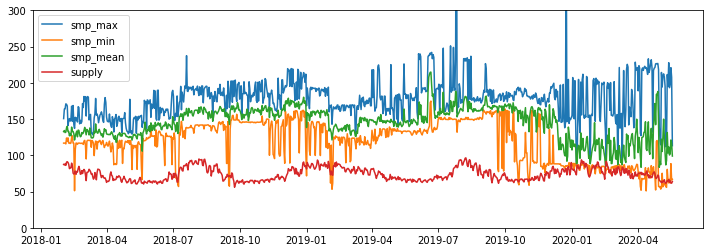

In [19]:
plt.rcParams['figure.figsize'] = [12, 4]
plt.plot(target.loc[:, 'date'], target.loc[:, 'smp_max'], label='smp_max')
plt.plot(target.loc[:, 'date'], target.loc[:, 'smp_min'], label='smp_min')
plt.plot(target.loc[:, 'date'], target.loc[:, 'smp_mean'], label='smp_mean')
plt.plot(target.loc[:, 'date'], target.loc[:, 'supply'], label='supply')
plt.ylim(0,300)
plt.legend()
plt.show()

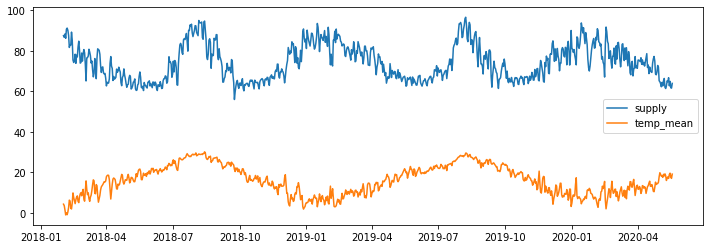

In [20]:
plt.rcParams['figure.figsize'] = [12, 4]
plt.plot(target.loc[:, 'date'], target.loc[:, 'supply'], label='supply')
plt.plot(target.loc[:, 'date'], target.loc[:, 'temp_mean'], label='temp_mean')
plt.legend()
plt.show()

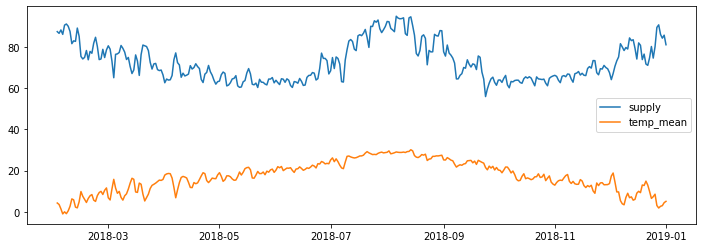

In [21]:
plt.rcParams['figure.figsize'] = [12, 4]
plt.plot(target.loc[:334, 'date'], target.loc[:334, 'supply'], label='supply')
plt.plot(target.loc[:334, 'date'], target.loc[:334, 'temp_mean'], label='temp_mean')
plt.legend()
plt.show()

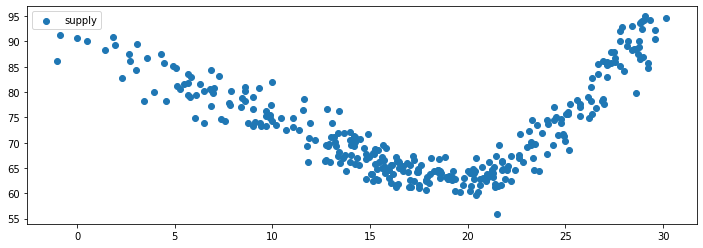

In [22]:
plt.rcParams['figure.figsize'] = [12, 4]
plt.scatter(target.loc[:334, 'temp_mean'], target.loc[:334, 'supply'], label='supply')
plt.legend()
plt.show()

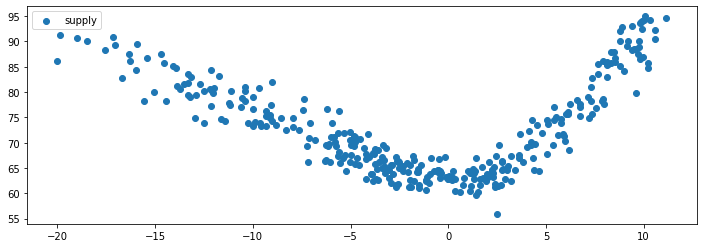

In [23]:
plt.rcParams['figure.figsize'] = [12, 4]
plt.scatter(target.loc[:334, 'temp_mean'] - 19, target.loc[:334, 'supply'], label='supply')
plt.legend()
plt.show()

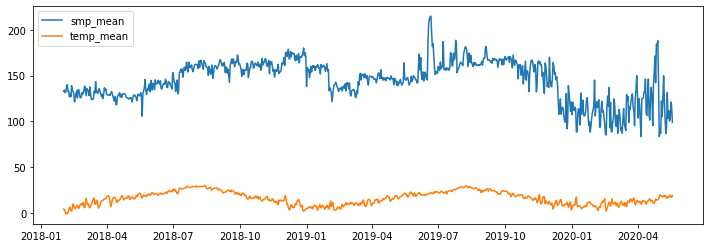

In [24]:
plt.rcParams['figure.figsize'] = [12, 4]
plt.plot(target.loc[:, 'date'], target.loc[:, 'smp_mean'], label='smp_mean')
plt.plot(target.loc[:, 'date'], target.loc[:, 'temp_mean'], label='temp_mean')
plt.legend()
plt.show()

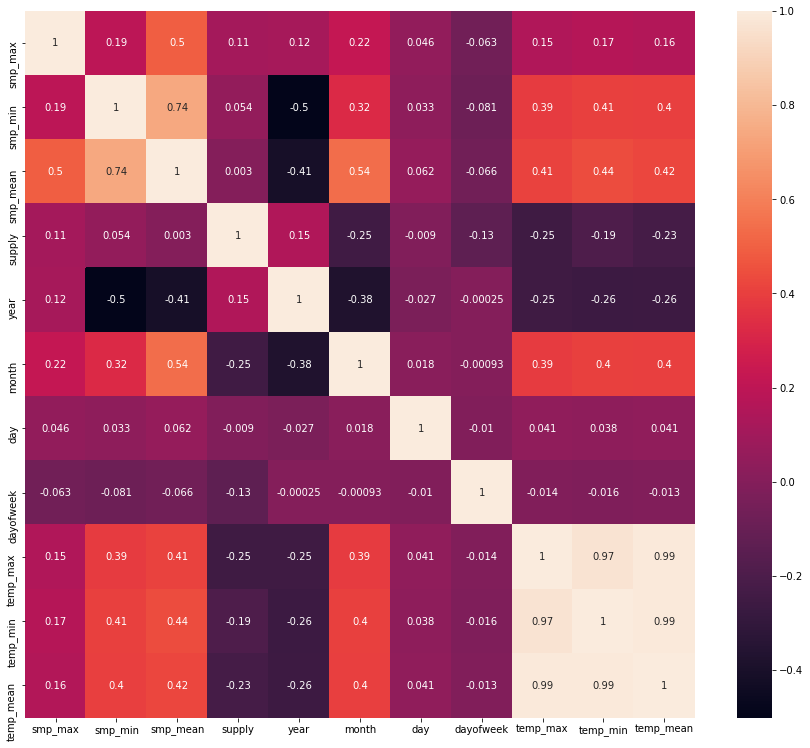

In [25]:
plt.rcParams['figure.figsize'] = [15, 13]
sns.heatmap(target.corr(), annot=True)

In [26]:
target

date  smp_max  smp_min  smp_mean  supply  year  month  day  \
0   2018-02-01   150.65   116.84    132.71   87.47  2018      2    1   
1   2018-02-02   163.86   116.84    134.19   86.64  2018      2    2   
2   2018-02-03   164.07   116.85    131.39   88.28  2018      2    3   
3   2018-02-04   171.00   115.76    131.89   86.14  2018      2    4   
4   2018-02-05   170.34   123.89    137.96   90.63  2018      2    5   
..         ...      ...      ...       ...     ...   ...    ...  ...   
833 2020-05-14   193.28    66.78    100.46   62.70  2020      5   14   
834 2020-05-15   198.23    61.81    102.38   64.91  2020      5   15   
835 2020-05-16   220.91    88.50    121.19   61.75  2020      5   16   
836 2020-05-17   207.75    65.78    116.82   61.55  2020      5   17   
837 2020-05-18   113.31    66.86     98.98   63.91  2020      5   18   

     dayofweek  temp_max  temp_min  temp_mean  
0            3      5.95      3.30   4.298077  
1            4      5.25      2.45   3.576923  
2            5      4.00     -0.50   1.457692  
3            6      0.30     -2.05  -1.000000  
4            0      2.05     -1.70   0.015385  
..         ...       ...       ...        ...  
833          3     22.35     14.95  18.942308  
834          4     21.50     18.40  19.605769  
835          5     19.05     15.75  17.628846  
836          6     20.35     14.30  17.030769  
837          0     22.45     16.55  19.134615  

[838 rows x 12 columns]

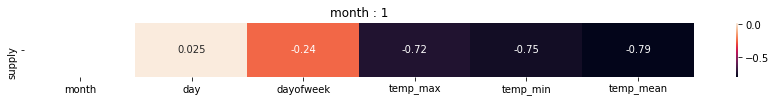

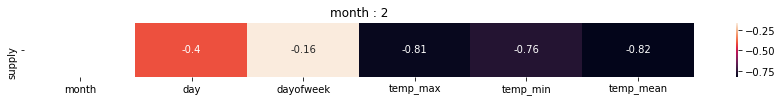

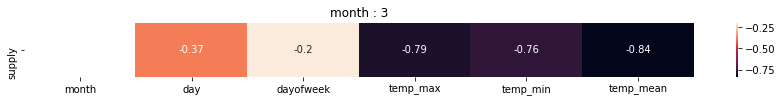

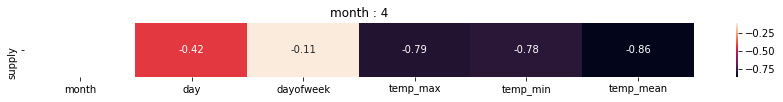

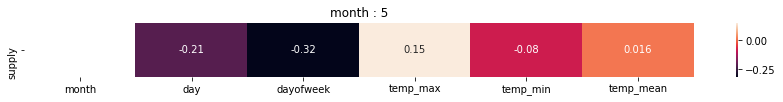

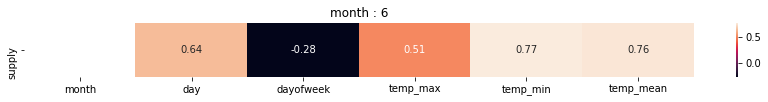

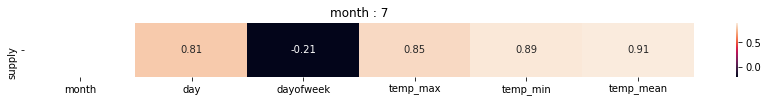

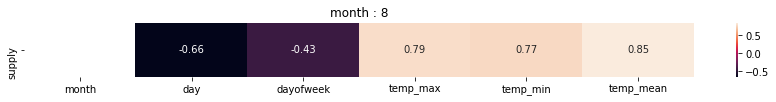

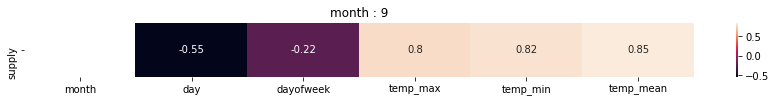

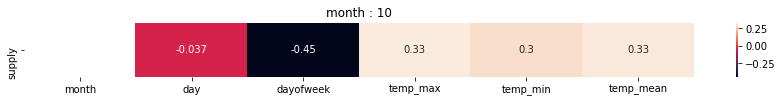

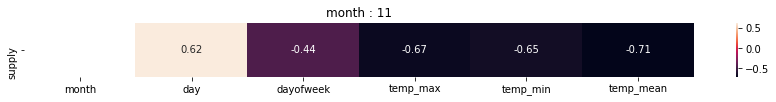

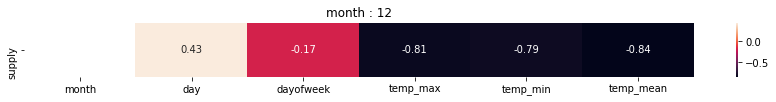

In [27]:
plt.rcParams['figure.figsize'] = [15, 1]
for m in range(1, 13):
    sns.heatmap(target[target['date'].dt.month == m].corr().loc[['supply'],['month', 'day', 'dayofweek', 'temp_max', 'temp_min', 'temp_mean']], annot=True)
    plt.title('month : '+ str(m))
    plt.show()

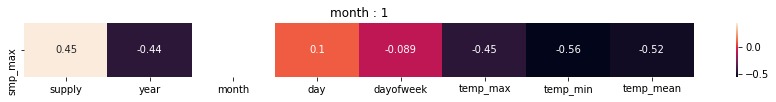

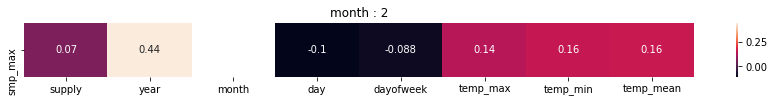

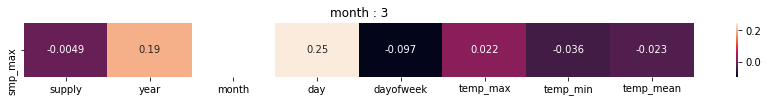

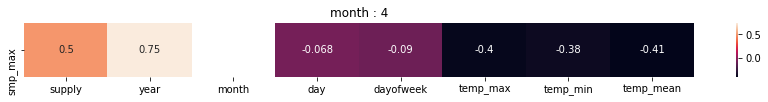

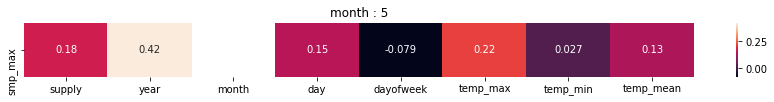

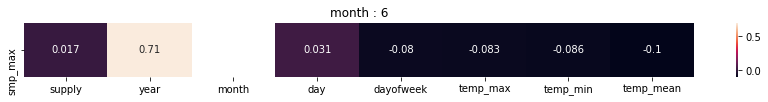

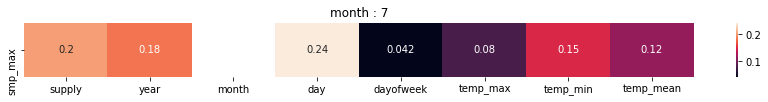

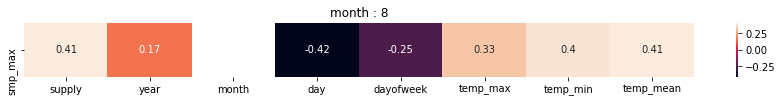

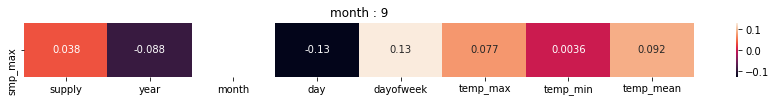

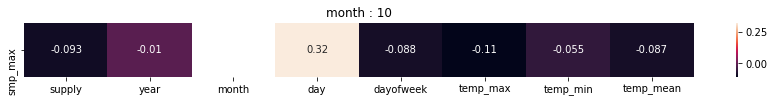

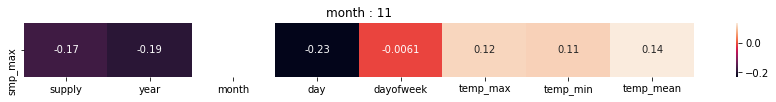

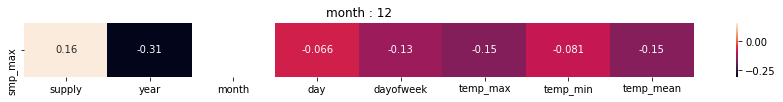

In [28]:
plt.rcParams['figure.figsize'] = [15, 1]
for m in range(1, 13):
    sns.heatmap(target[target['date'].dt.month == m].corr().loc[['smp_max'],'supply':], annot=True)
    plt.title('month : '+ str(m))
    plt.show()

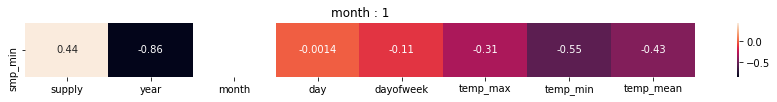

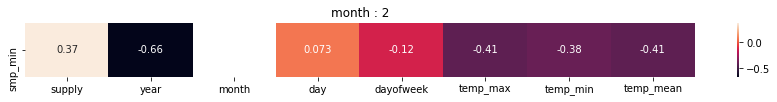

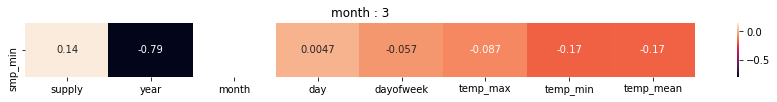

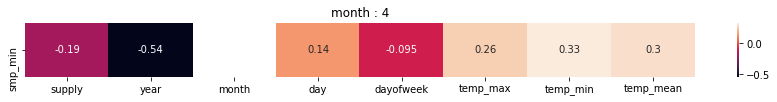

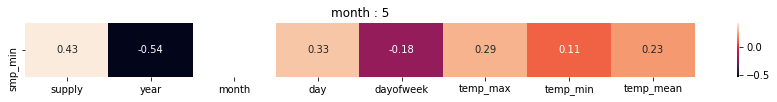

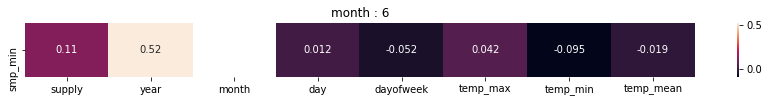

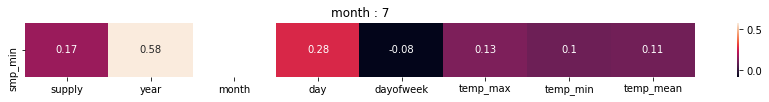

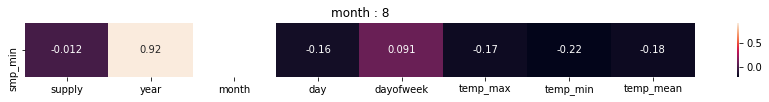

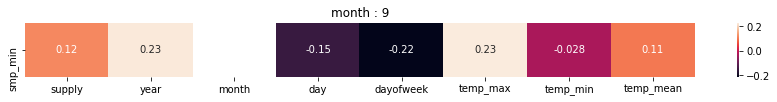

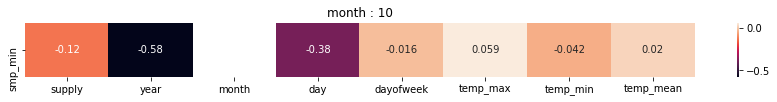

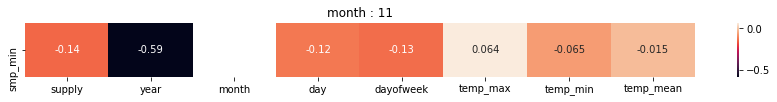

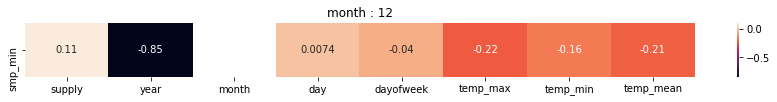

In [29]:
plt.rcParams['figure.figsize'] = [15, 1]
for m in range(1, 13):
    sns.heatmap(target[target['date'].dt.month == m].corr().loc[['smp_min'],'supply':], annot=True)
    plt.title('month : '+ str(m))
    plt.show()

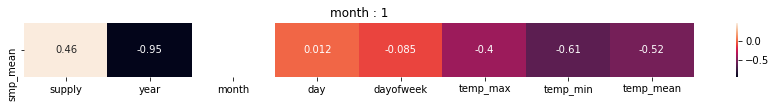

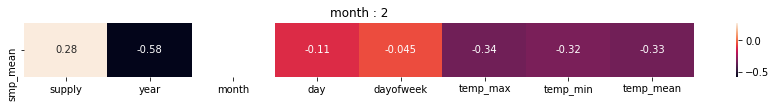

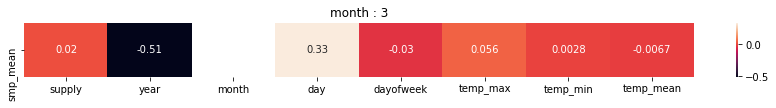

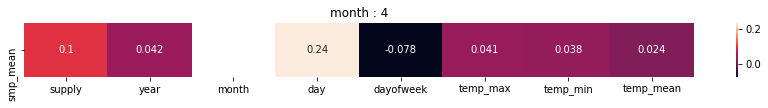

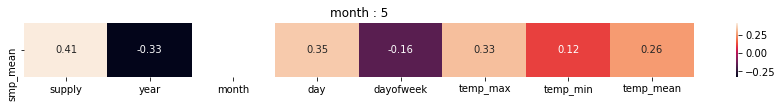

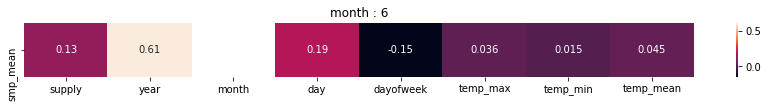

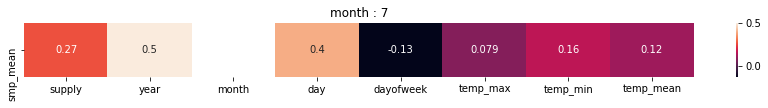

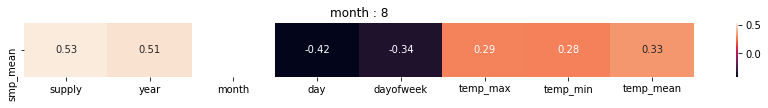

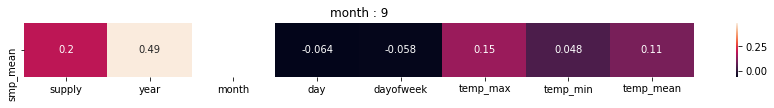

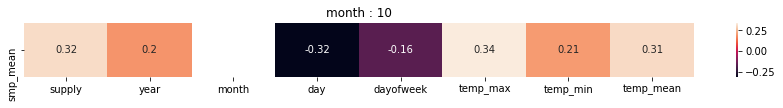

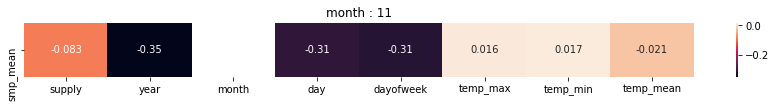

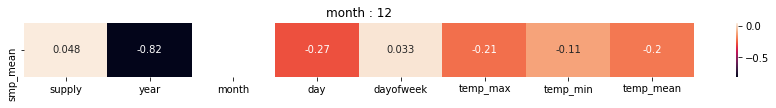

In [30]:
plt.rcParams['figure.figsize'] = [15, 1]
for m in range(1, 13):
    sns.heatmap(target[target['date'].dt.month == m].corr().loc[['smp_mean'],'supply':], annot=True)
    plt.title('month : '+ str(m))
    plt.show()

# 5. 모델 학습 및 검증
- lgbm을 이용하여 2가지 모델 작성

 
- 1) 과거 정보를 이용해 supply, 기상정보를 예측하는 모델 (시계열 모델)

    - 2) supply, 기상정보를 이용하여 smp를 예측하는 모델 (상관관계 모델)

- 1)의 모델을 이용해 supply, 기상정보를 예측한 후 2)의 모델로 smp를 예측

In [31]:
def create_model(train, val):
    params = {
        'metric': 'mae',
        'seed':7777
        }

    model = lgb.train(params, d_train, 1000, d_val, verbose_eval=1000, early_stopping_rounds=100)
    
    plt.rcParams['figure.figsize'] = [6, 4]
    plt.plot(np.array(y_val), '.-', label='y_val')
    plt.plot(model.predict(x_val), '.-', label='y_pred')
    plt.title(str(future)+'days later')
    plt.legend()
    plt.show()

    return model

In [32]:
def trans(dataset, start_index, end_index, past, future, x_columns, y_columns):
    dataset.index = range(dataset.shape[0])
    data = []
    labels = []
    
    start_index = start_index + past
    
    if end_index is None:
        end_index = dataset.shape[0]
    
    for i in range(start_index, end_index-future):
        indices = np.array(dataset.loc[i-past:i, x_columns])
        data.append(indices)
        
        labels.append(np.array(dataset.loc[i+future, y_columns]))
        
    data = np.array(data)
    data = data.reshape(data.shape[0], -1)
    labels = np.array(labels)
    labels = labels.reshape(-1)
    
    return data, labels

In [33]:
past = 29 # 최근 30일 정보를 이용하여 n일 후를 예측

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[35]	valid_0's l1: 3.37013


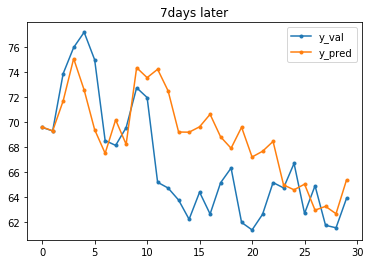

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[90]	valid_0's l1: 3.65347


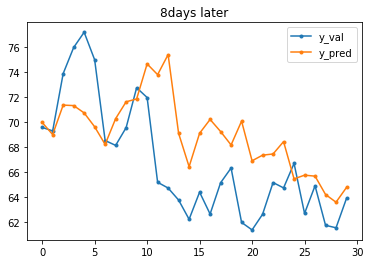

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[54]	valid_0's l1: 4.16792


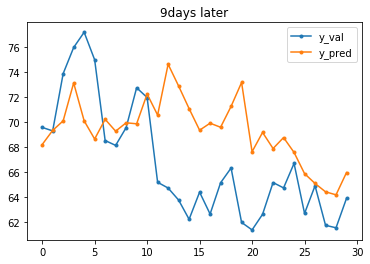

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[35]	valid_0's l1: 4.37341


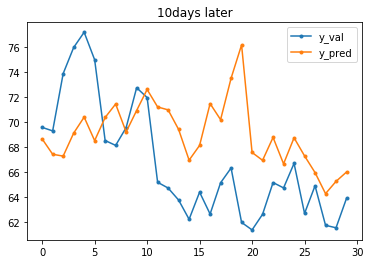

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[34]	valid_0's l1: 4.70251


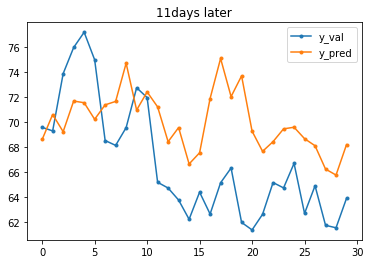

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[204]	valid_0's l1: 4.0814


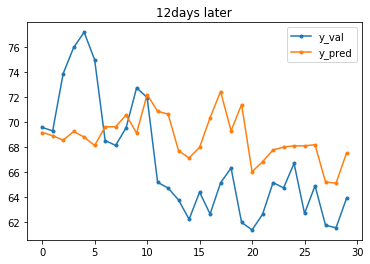

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	valid_0's l1: 4.39813


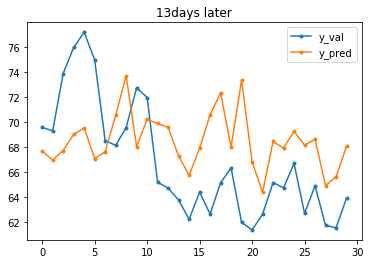

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[141]	valid_0's l1: 3.79334


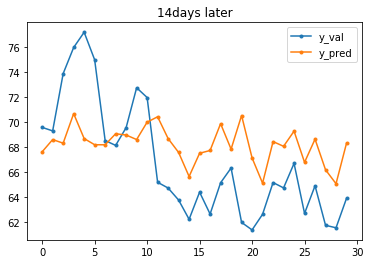

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[51]	valid_0's l1: 4.31826


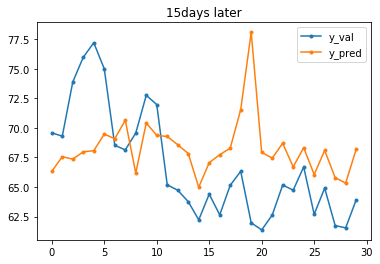

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[31]	valid_0's l1: 4.24249


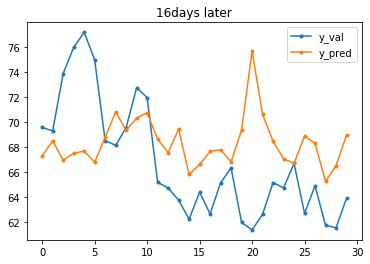

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[46]	valid_0's l1: 4.5661


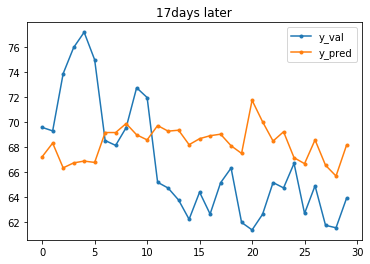

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[39]	valid_0's l1: 4.45102


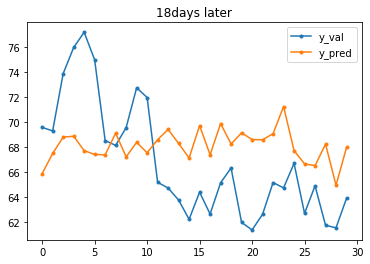

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[42]	valid_0's l1: 4.33777


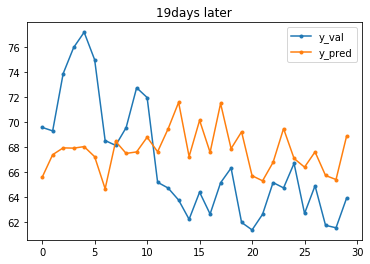

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[88]	valid_0's l1: 4.68244


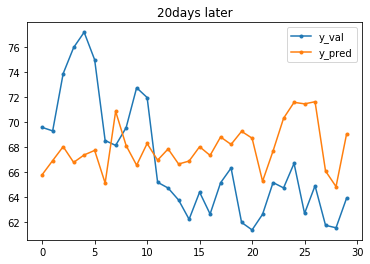

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[92]	valid_0's l1: 4.60929


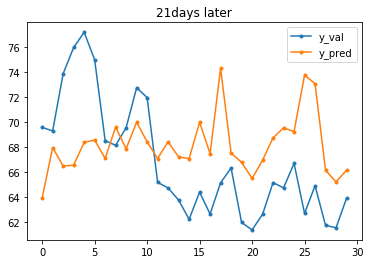

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[42]	valid_0's l1: 5.25976


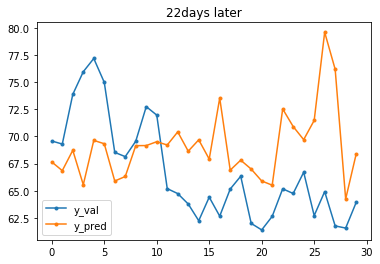

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[35]	valid_0's l1: 4.5404


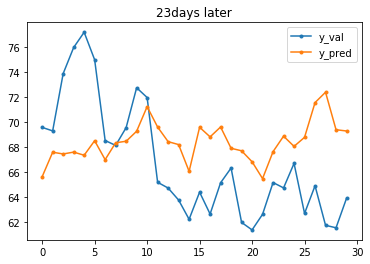

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[36]	valid_0's l1: 3.94603


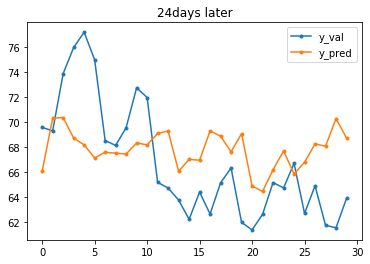

Training until validation scores don't improve for 100 rounds
[1000]	valid_0's l1: 3.92458
Did not meet early stopping. Best iteration is:
[997]	valid_0's l1: 3.92456


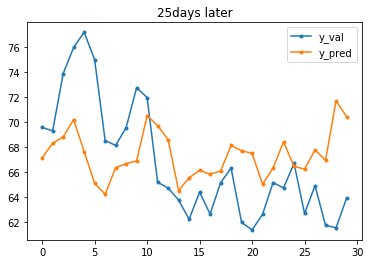

Training until validation scores don't improve for 100 rounds
[1000]	valid_0's l1: 3.81605
Did not meet early stopping. Best iteration is:
[991]	valid_0's l1: 3.81596


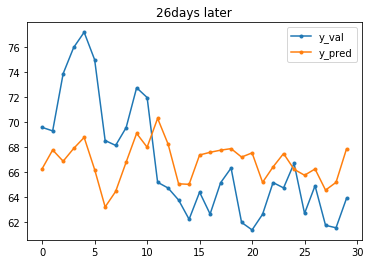

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[47]	valid_0's l1: 3.44402


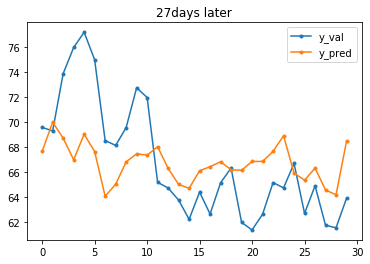

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[59]	valid_0's l1: 3.38684


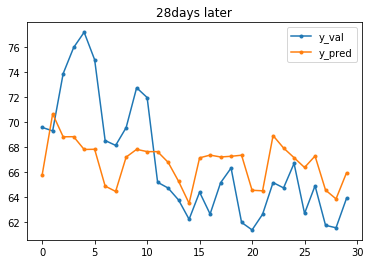

Training until validation scores don't improve for 100 rounds
[1000]	valid_0's l1: 3.39899
Did not meet early stopping. Best iteration is:
[997]	valid_0's l1: 3.39895


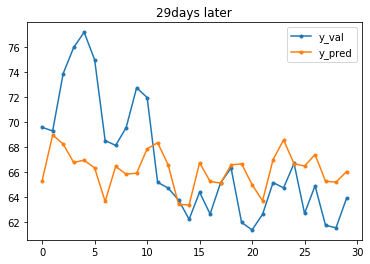

Training until validation scores don't improve for 100 rounds
[1000]	valid_0's l1: 2.80167
Did not meet early stopping. Best iteration is:
[992]	valid_0's l1: 2.80162


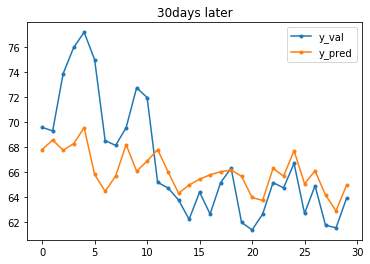

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[144]	valid_0's l1: 3.05351


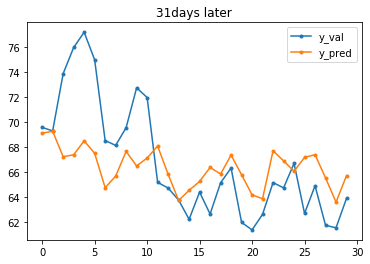

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[51]	valid_0's l1: 2.94904


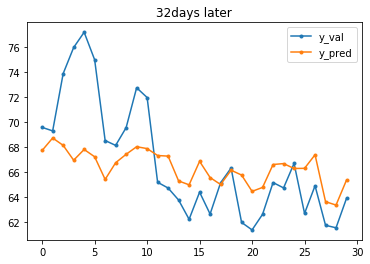

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[260]	valid_0's l1: 2.78249


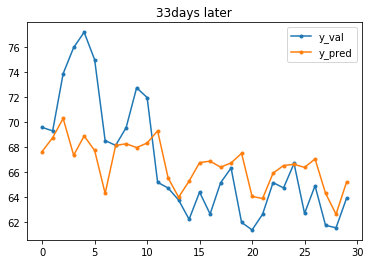

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[78]	valid_0's l1: 2.70215


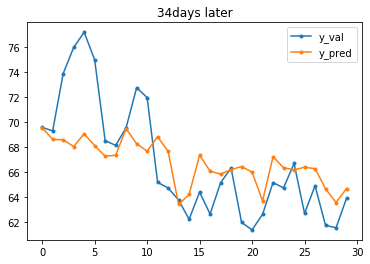

In [34]:
x_columns = ['year', 'month', 'day', 'dayofweek', 'supply', 'temp_max', 'temp_min', 'temp_mean']
y_columns = ['supply']
supply_models = {}
scores = []

# 7일~34일 후를 예측하는 각각의 모델 구축
for future in range(7, 35):
    train_split = target.shape[0]-past-future-30 # 마지막 30일을 validation set으로 사용
    x_train, y_train = trans(target, 0, train_split, past, future, x_columns, y_columns)
    x_val, y_val = trans(target, train_split, None, past, future, x_columns, y_columns)
    
    d_train = lgb.Dataset(x_train, y_train)
    d_val = lgb.Dataset(x_val, y_val)

    supply_models[future] = create_model(d_train, d_val)
    
    scores.append(dict(supply_models[future].best_score)['valid_0']['l1'])
    
    print('==========================================================================')

In [35]:
mean_score = 0

for future, score in zip(range(7, 35), scores):
    print(f"{future:2} : {score}")
    
    mean_score += score
print("mean", mean_score / len(scores))

 7 : 3.3701272165679748
 8 : 3.653473602085275
 9 : 4.167920748303284
10 : 4.37341458277854
11 : 4.7025092626814
12 : 4.0814001088214
13 : 4.398134268710762
14 : 3.7933360606312045
15 : 4.3182633869865095
16 : 4.242493215538151
17 : 4.566099728401983
18 : 4.451020225352104
19 : 4.337766949337546
20 : 4.6824369163950825
21 : 4.609294858926705
22 : 5.259755918871256
23 : 4.540403681738045
24 : 3.9460322865024904
25 : 3.924562891875547
26 : 3.8159638092965635
27 : 3.4440185212275165
28 : 3.386842620543941
29 : 3.398947686739605
30 : 2.801615029116538
31 : 3.0535116936785576
32 : 2.9490362801219967
33 : 2.782492643356726
34 : 2.7021522587776747
mean 3.9197509447630137


In [36]:
x_columns = ['year', 'month', 'day', 'temp_max', 'temp_min', 'temp_mean']

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[6]	valid_0's l1: 1.93806


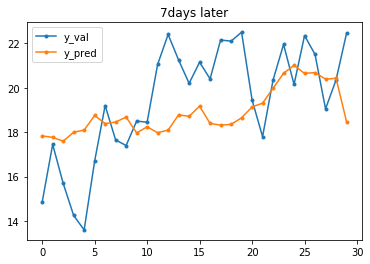

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[15]	valid_0's l1: 1.88958


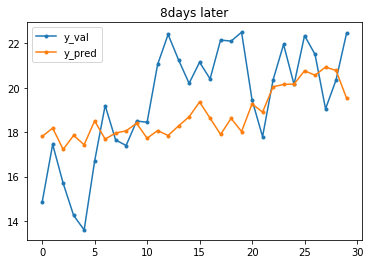

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[17]	valid_0's l1: 1.84869


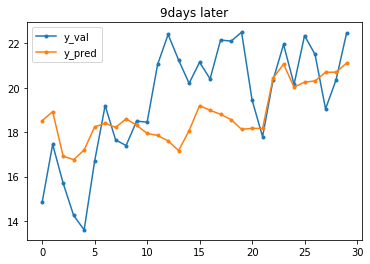

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[21]	valid_0's l1: 1.86814


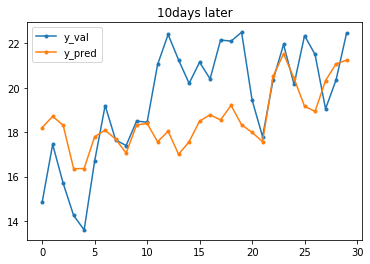

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4]	valid_0's l1: 1.88072


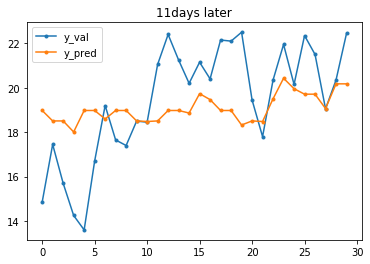

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[7]	valid_0's l1: 2.05935


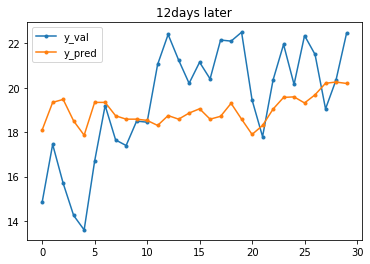

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[6]	valid_0's l1: 1.99617


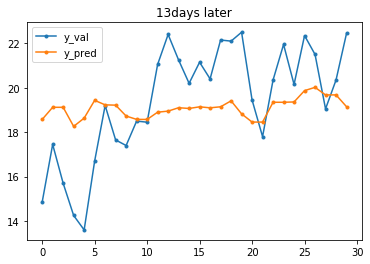

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[26]	valid_0's l1: 1.90405


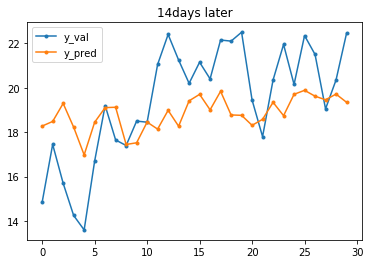

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[8]	valid_0's l1: 1.99432


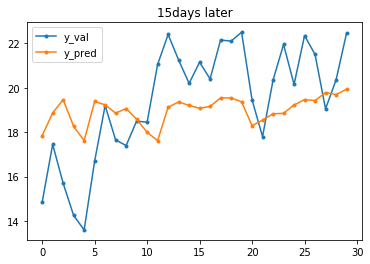

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[45]	valid_0's l1: 1.84558


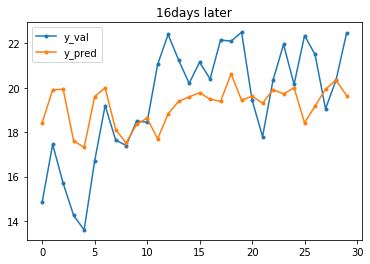

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4]	valid_0's l1: 1.98909


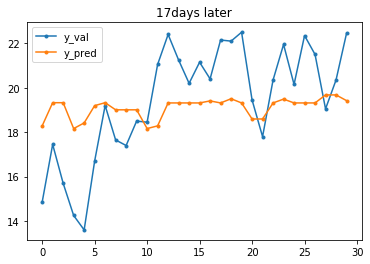

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[20]	valid_0's l1: 1.91602


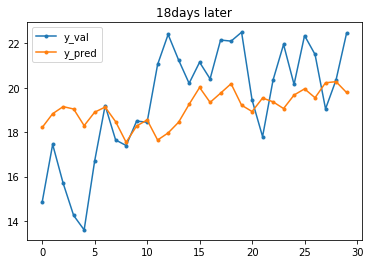

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[27]	valid_0's l1: 1.80643


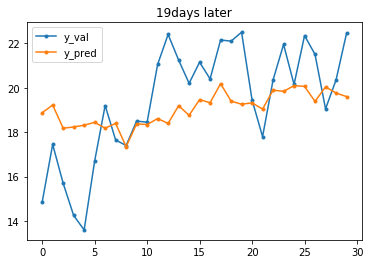

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[26]	valid_0's l1: 1.9453


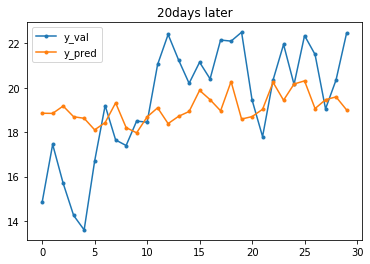

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[5]	valid_0's l1: 1.91479


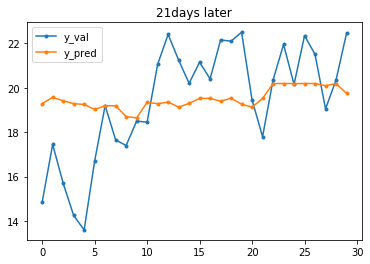

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[22]	valid_0's l1: 1.79498


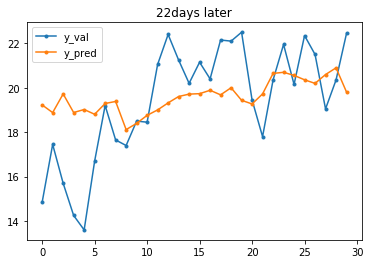

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[18]	valid_0's l1: 1.85747


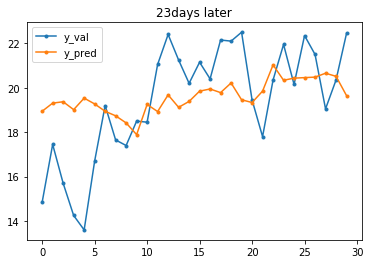

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[14]	valid_0's l1: 1.73656


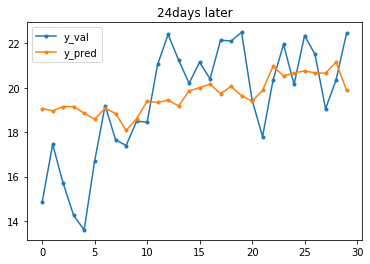

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[45]	valid_0's l1: 1.71718


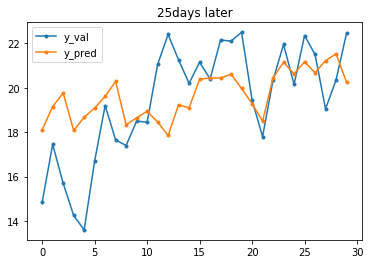

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[38]	valid_0's l1: 1.77672


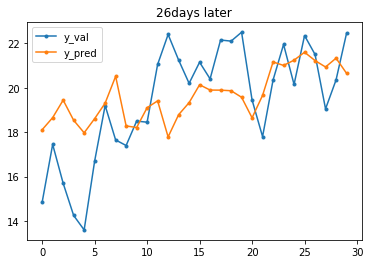

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[128]	valid_0's l1: 1.784


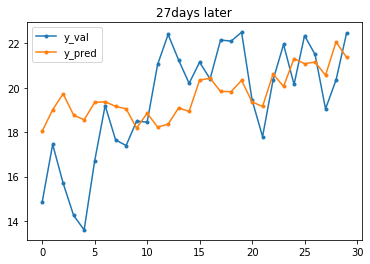

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[91]	valid_0's l1: 1.75183


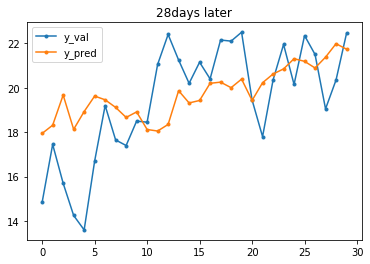

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[91]	valid_0's l1: 1.76685


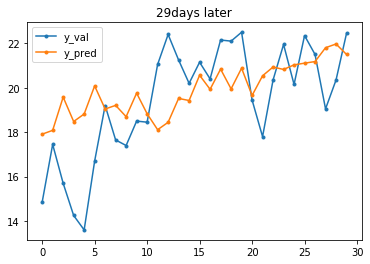

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[41]	valid_0's l1: 1.75899


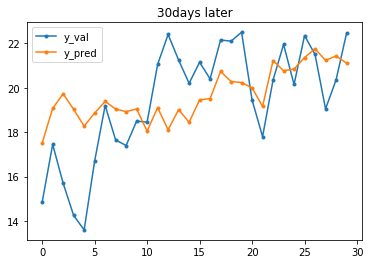

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[109]	valid_0's l1: 1.8838


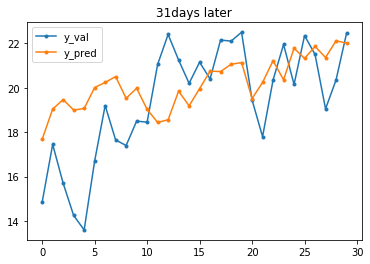

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[93]	valid_0's l1: 1.66223


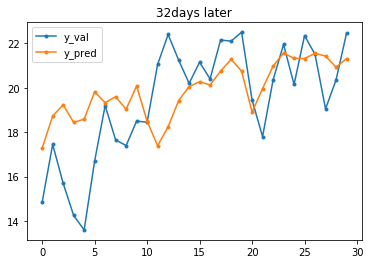

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[12]	valid_0's l1: 1.81751


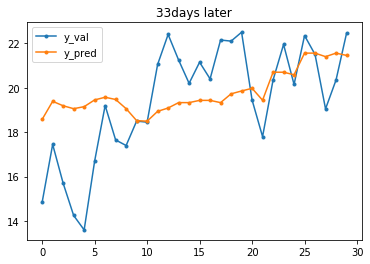

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[12]	valid_0's l1: 1.80528


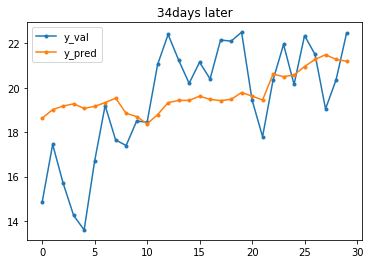

In [42]:
y_columns = ['temp_max']
temp_max_models = {}
scores = []

# 7일~34일 후를 예측하는 각각의 모델 구축
for future in range(7, 35):
    train_split = target.shape[0]-past-future-30
    x_train, y_train = trans(target, 0, train_split, past, future, x_columns, y_columns)
    x_val, y_val = trans(target, train_split, None, past, future, x_columns, y_columns)
    
    d_train = lgb.Dataset(x_train, y_train)
    d_val = lgb.Dataset(x_val, y_val)

    temp_max_models[future] = create_model(d_train, d_val)
    
    scores.append(dict(temp_max_models[future].best_score)['valid_0']['l1'])

    print('==========================================================================')

In [43]:
mean_score = 0

for future, score in zip(range(7, 35), scores):
    print(f"{future:2} : {score}")
    
    mean_score += score
print("mean", mean_score / len(scores))

 7 : 1.938062239783678
 8 : 1.889584831349397
 9 : 1.8486923204942123
10 : 1.8681432463197545
11 : 1.880724552635659
12 : 2.059347935731251
13 : 1.9961715123843737
14 : 1.9040494749552859
15 : 1.994317410940759
16 : 1.8455819578536017
17 : 1.9890945789748862
18 : 1.9160210016271202
19 : 1.8064314531351178
20 : 1.9452993165858639
21 : 1.914791552057046
22 : 1.7949764376959443
23 : 1.8574676349985701
24 : 1.7365587370591902
25 : 1.717175298931565
26 : 1.7767218319374019
27 : 1.7839989927852655
28 : 1.7518308222978272
29 : 1.7668473606163748
30 : 1.7589885901301134
31 : 1.8838009445246826
32 : 1.6622290936763418
33 : 1.8175088736029053
34 : 1.8052796749035442
mean 1.8539177742138475


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[18]	valid_0's l1: 2.10682


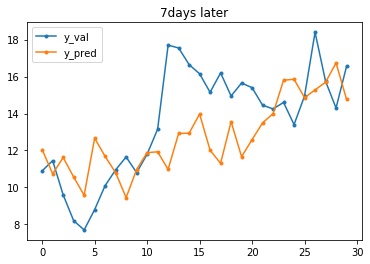

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[10]	valid_0's l1: 2.13751


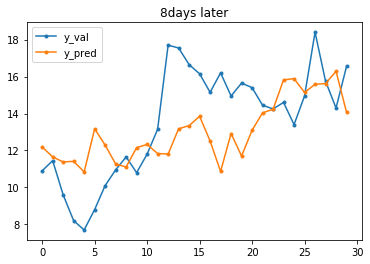

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[27]	valid_0's l1: 2.3342


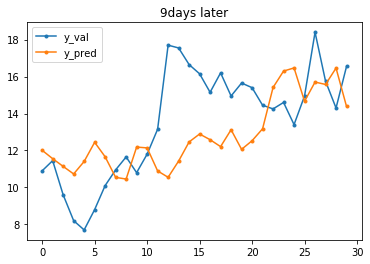

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[31]	valid_0's l1: 2.23053


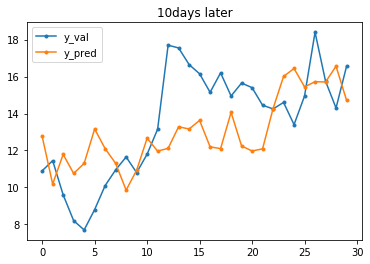

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[42]	valid_0's l1: 2.2732


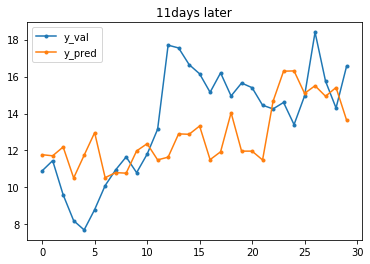

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[13]	valid_0's l1: 2.28065


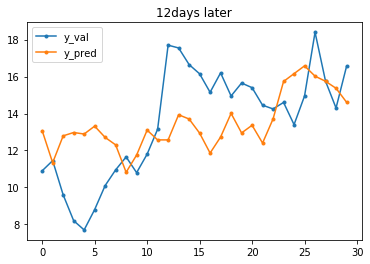

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[7]	valid_0's l1: 2.20257


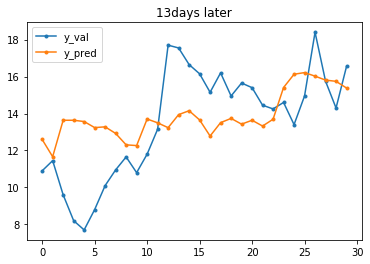

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[15]	valid_0's l1: 2.17865


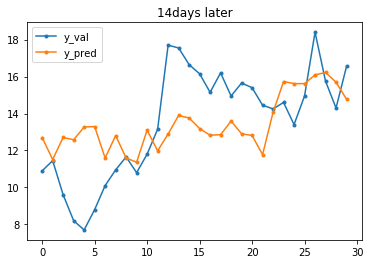

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[18]	valid_0's l1: 2.17244


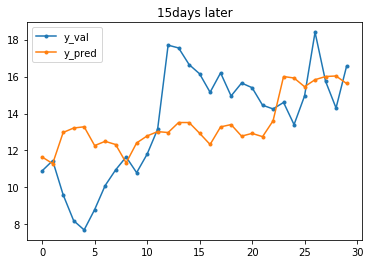

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[21]	valid_0's l1: 2.04645


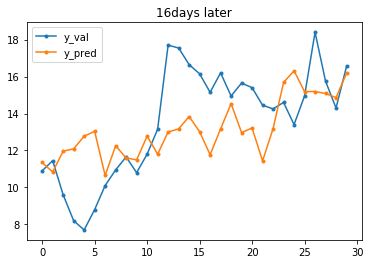

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[8]	valid_0's l1: 2.25942


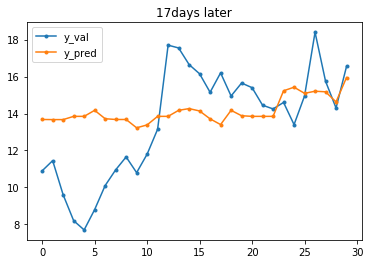

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 2.42899


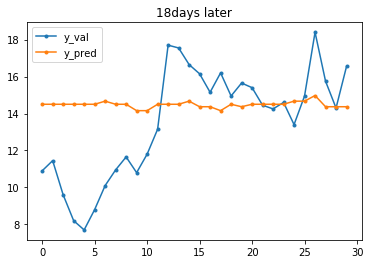

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[10]	valid_0's l1: 2.31391


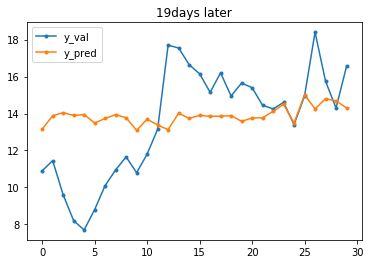

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[21]	valid_0's l1: 2.37363


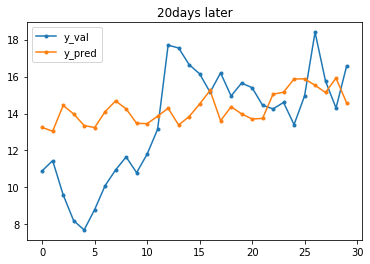

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[28]	valid_0's l1: 2.20156


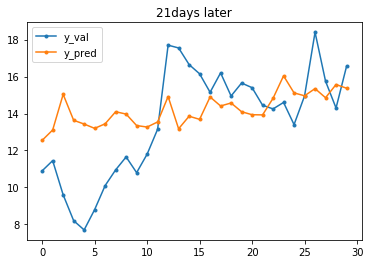

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[17]	valid_0's l1: 2.24308


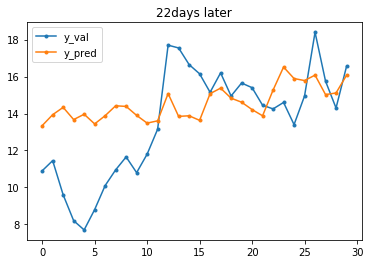

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[37]	valid_0's l1: 2.31012


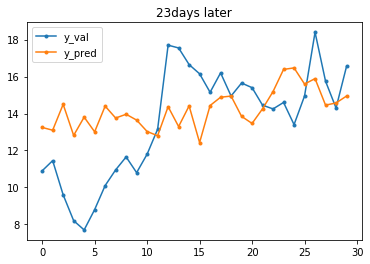

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[14]	valid_0's l1: 2.27835


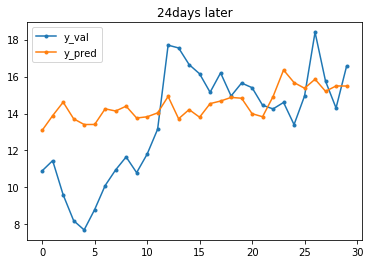

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[66]	valid_0's l1: 2.30703


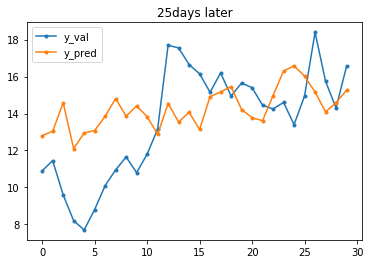

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[11]	valid_0's l1: 2.30082


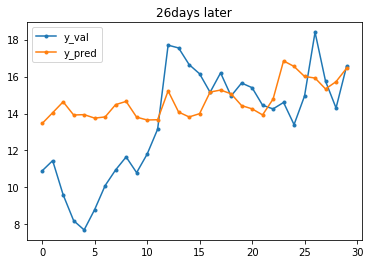

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[9]	valid_0's l1: 2.23807


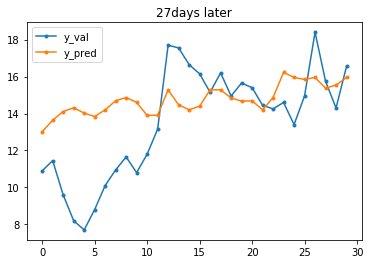

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[51]	valid_0's l1: 2.18869


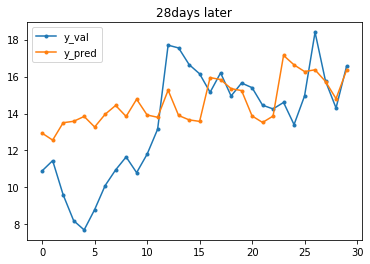

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[112]	valid_0's l1: 2.03065


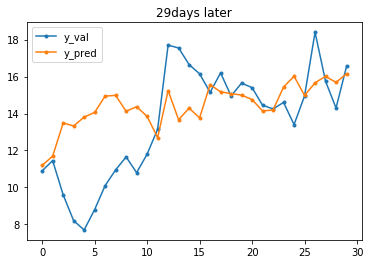

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[411]	valid_0's l1: 2.13319


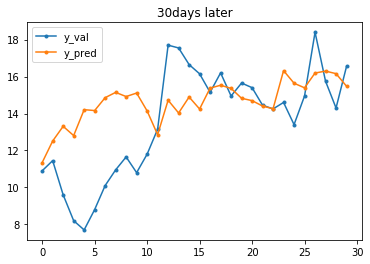

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[243]	valid_0's l1: 2.01297


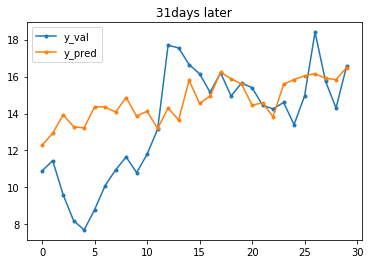

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[47]	valid_0's l1: 2.14907


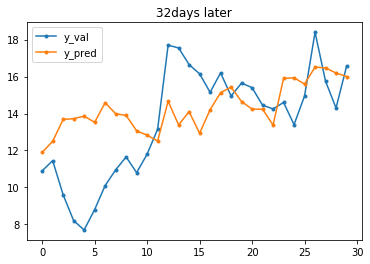

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[22]	valid_0's l1: 2.21201


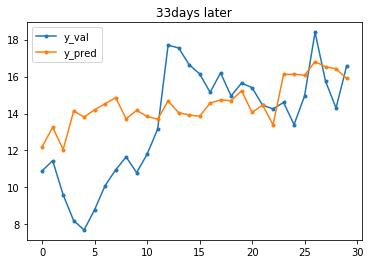

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[66]	valid_0's l1: 2.10178


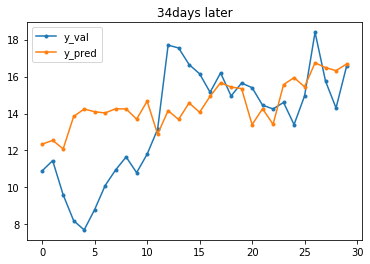

In [38]:
y_columns = ['temp_min']
temp_min_models = {}

# 7일~34일 후를 예측하는 각각의 모델 구축
for future in range(7, 35):
    train_split = target.shape[0]-past-future-30
    x_train, y_train = trans(target, 0, train_split, past, future, x_columns, y_columns)
    x_val, y_val = trans(target, train_split, None, past, future, x_columns, y_columns)
    
    d_train = lgb.Dataset(x_train, y_train)
    d_val = lgb.Dataset(x_val, y_val)

    temp_min_models[future] = create_model(d_train, d_val)
    print('==========================================================================')

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[8]	valid_0's l1: 2.02477


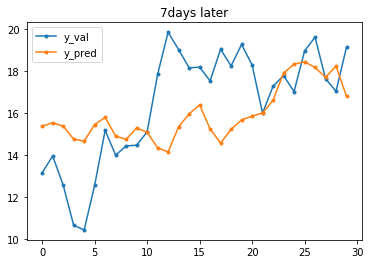

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[21]	valid_0's l1: 2.03354


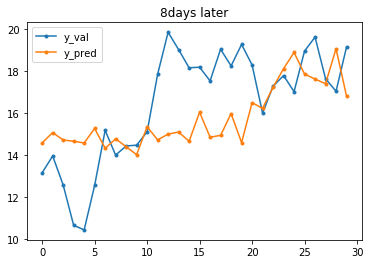

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[8]	valid_0's l1: 2.01944


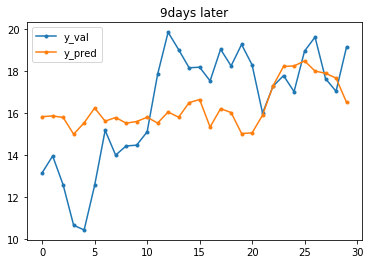

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[5]	valid_0's l1: 1.99865


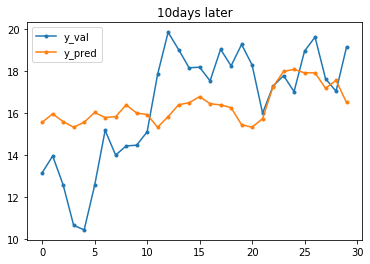

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[15]	valid_0's l1: 1.98191


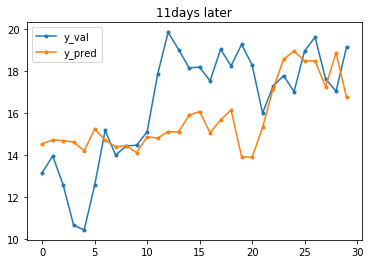

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[26]	valid_0's l1: 1.95354


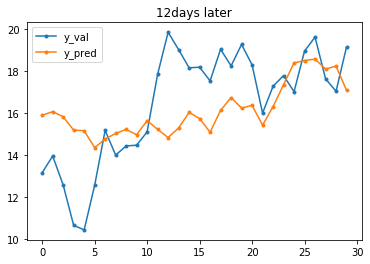

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[8]	valid_0's l1: 1.97646


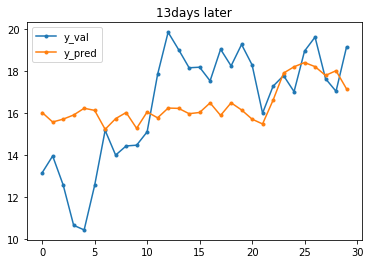

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[17]	valid_0's l1: 2.02888


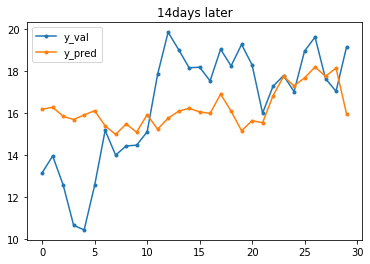

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[5]	valid_0's l1: 2.0162


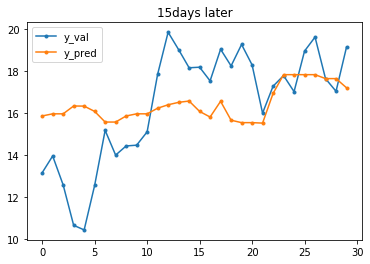

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[5]	valid_0's l1: 2.02342


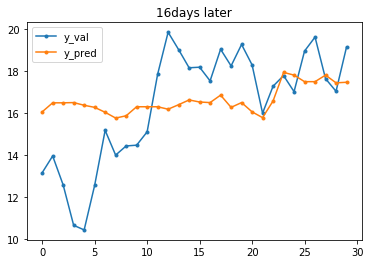

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[5]	valid_0's l1: 1.98469


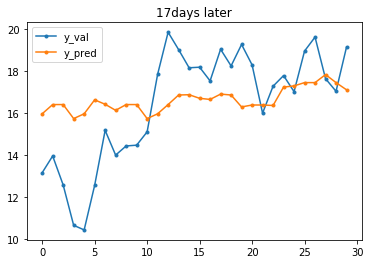

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 2.14574


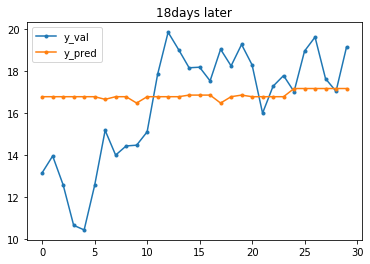

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[26]	valid_0's l1: 2.0209


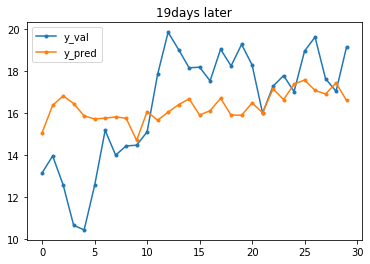

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[21]	valid_0's l1: 2.13406


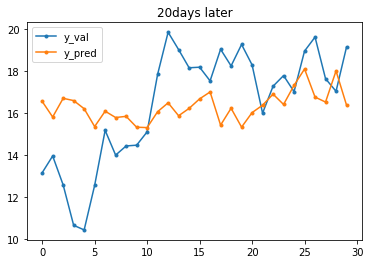

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[23]	valid_0's l1: 1.99638


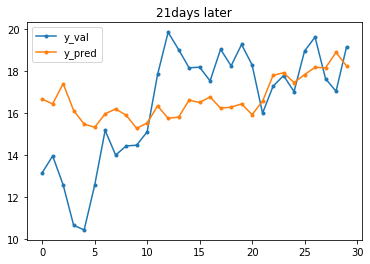

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[24]	valid_0's l1: 1.9636


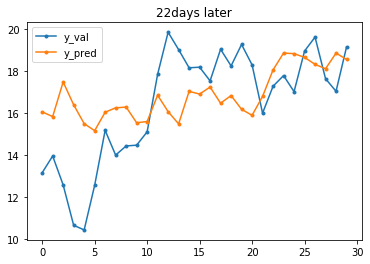

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[15]	valid_0's l1: 2.02128


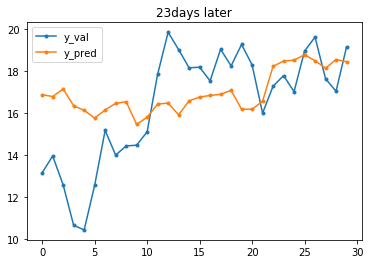

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[50]	valid_0's l1: 1.97633


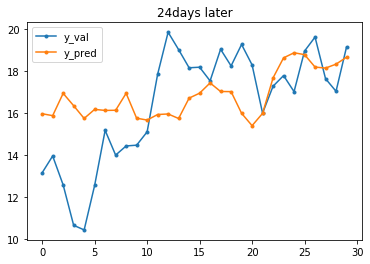

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[41]	valid_0's l1: 1.90863


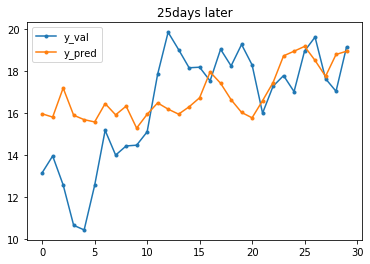

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[67]	valid_0's l1: 1.96563


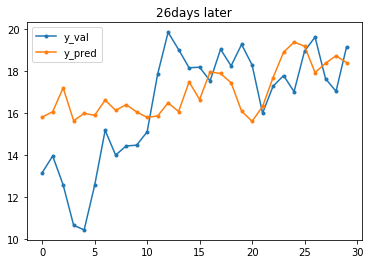

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[36]	valid_0's l1: 1.93084


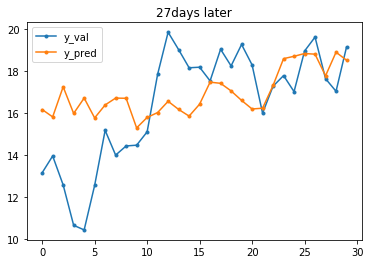

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[48]	valid_0's l1: 1.88876


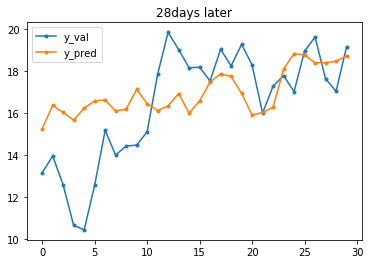

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[72]	valid_0's l1: 1.93516


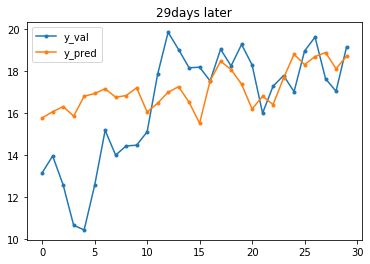

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[45]	valid_0's l1: 1.92617


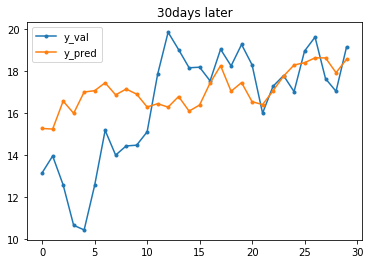

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[51]	valid_0's l1: 1.98859


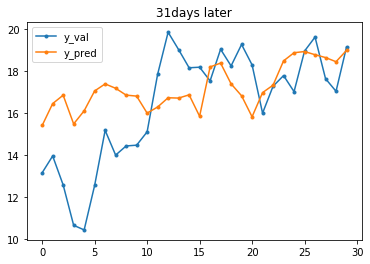

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[67]	valid_0's l1: 2.03271


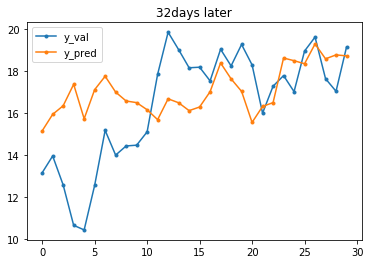

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[123]	valid_0's l1: 1.96517


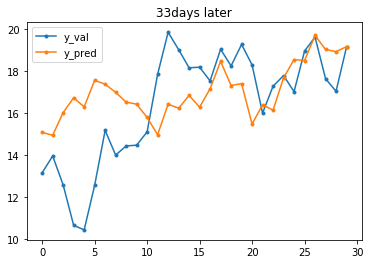

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[18]	valid_0's l1: 2.06545


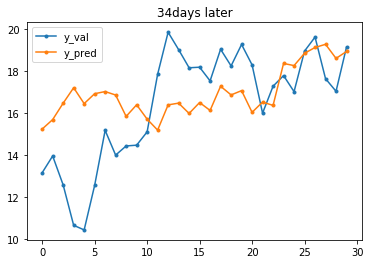

In [39]:
y_columns = ['temp_mean']
temp_mean_models = {}

# 7일~34일 후를 예측하는 각각의 모델 구축
for future in range(7, 35):
    train_split = target.shape[0]-past-future-30
    x_train, y_train = trans(target, 0, train_split, past, future, x_columns, y_columns)
    x_val, y_val = trans(target, train_split, None, past, future, x_columns, y_columns)
    
    d_train = lgb.Dataset(x_train, y_train)
    d_val = lgb.Dataset(x_val, y_val)

    temp_mean_models[future] = create_model(d_train, d_val)
    print('==========================================================================')

In [40]:
x_test = np.array(target.loc[700:, ['year', 'month', 'day', 'dayofweek', 'supply', 'temp_max', 'temp_min', 'temp_mean']])
x_test = x_test.reshape(1,-1)

In [41]:
supply_result=[]
for future in range(7, 35):
    supply_result.append(supply_models[future].predict(x_test))
supply_result = np.array(supply_result).reshape(-1)

LightGBMError: The number of features in data (1104) is not the same as it was in training data (240).

In [ ]:
x_test = np.array(target.loc[700:, ['year', 'month', 'day', 'temp_max', 'temp_min', 'temp_mean']])
x_test = x_test.reshape(1,-1)

In [ ]:
temp_max_result=[]
for future in range(7, 35):
    temp_max_result.append(temp_max_models[future].predict(x_test))
temp_max_result = np.array(temp_max_result).reshape(-1)

In [ ]:
temp_min_result=[]
for future in range(7, 35):
    temp_min_result.append(temp_min_models[future].predict(x_test))
temp_min_result = np.array(temp_min_result).reshape(-1)

In [ ]:
temp_mean_result=[]
for future in range(7, 35):
    temp_mean_result.append(temp_mean_models[future].predict(x_test))
temp_mean_result = np.array(temp_mean_result).reshape(-1)

In [ ]:
submission = pd.read_csv('data/sample_submission.csv')
submission_bottom_half = submission.loc[28:,:]
submission = submission.loc[:27, :]
test = submission.copy()
test['date'] = pd.to_datetime(test['date'])
test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day
test['dayofweek'] = test['date'].dt.dayofweek
test['supply'] = np.array(supply_result).reshape(-1)
test['temp_max'] = np.array(temp_max_result).reshape(-1)
test['temp_min'] = np.array(temp_min_result).reshape(-1)
test['temp_mean'] = np.array(temp_mean_result).reshape(-1)
test.head()

In [ ]:
def create_model(x_data, y_data, k=5):
    models = []
    
    k_fold = KFold(n_splits=k, shuffle=True, random_state=77)
    
    for train_idx, val_idx in k_fold.split(x_data):
        x_train, y_train = x_data.iloc[train_idx], y_data[train_idx]
        x_val, y_val = x_data.iloc[val_idx], y_data[val_idx]
    
        d_train = lgb.Dataset(x_train, y_train)
        d_val = lgb.Dataset(x_val, y_val)

        params = {
            'metric': 'mse',
            'seed':777
            }

        model = lgb.train(params, d_train, 1000, d_val, verbose_eval=1000, early_stopping_rounds=100)
        
        plt.rcParams['figure.figsize'] = [12, 4]
        plt.plot(np.array(y_val), '.-', label='y_val')
        plt.plot(model.predict(x_val), '.-', label='y_pred')
        plt.legend()
        plt.show()
        models.append(model)

    return models

In [ ]:
x_train = target.loc[:, ['supply', 'year', 'month', 'day', 'dayofweek', 'temp_max', 'temp_min', 'temp_mean']]
y_train = target.loc[:, ['smp_min', 'smp_max', 'smp_mean' ]]

smp_models = {}
for label in y_train.columns:
    print('train column : ', label)
    smp_models[label] = create_model(x_train, y_train[label])
    print('==========================================================================')

In [ ]:
x_test = test.loc[:,['supply', 'year', 'month', 'day', 'dayofweek', 'temp_max', 'temp_min', 'temp_mean']]
for label in ['smp_min', 'smp_max', 'smp_mean']:
    preds = []
    for i in range(5):
        preds.append(smp_models[label][i].predict(x_test))
    pred = sum(preds)/len(preds)
    test[label] = pred

In [ ]:
submission.loc[:, ['smp_min', 'smp_max', 'smp_mean', 'supply']] = test.loc[:,['smp_min', 'smp_max', 'smp_mean', 'supply']]
submission = pd.concat([submission, submission_bottom_half], axis = 0)
submission

In [ ]:
submission.to_csv('Dacon_baseline_v2.csv', index=False)